## Imagenette 160px

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import accuracy

In [3]:
path = untar_data(URLs.IMAGENETTE_160); path

PosixPath('/home/jupyter/.fastai/data/imagenette-160')

In [4]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/imagenette-160/val'),
 PosixPath('/home/jupyter/.fastai/data/imagenette-160/train'),
 PosixPath('/home/jupyter/.fastai/data/imagenette-160/models')]

In [5]:
tfms = get_transforms(max_rotate=25); len(tfms)

2

In [6]:
bs = 64; size = 160

In [7]:
data = (ImageList.from_folder(path).split_by_folder(valid='val')
            .label_from_folder().transform(tfms, size=size)
            .databunch(bs=bs)
            .normalize(imagenet_stats))

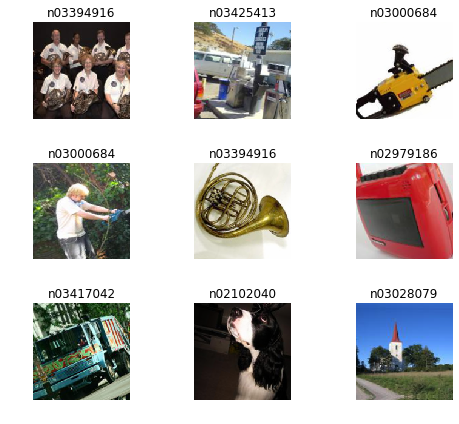

In [8]:
data.show_batch(rows=3, figsize=(7,6))

In [9]:
print(data.classes)
print(len(data.classes)),data.c

['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']
10


(None, 10)

In [10]:
help(res_block)

Help on function res_block in module fastai.layers:

res_block(nf, dense: bool = False, norm_type: Union[fastai.layers.NormType, NoneType] = <NormType.Batch: 1>, bottle: bool = False, **conv_kwargs)
    Resnet block of `nf` features. `conv_kwargs` are passed to `conv_layer`.



In [11]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 160, 160]), torch.Size([64]))

In [12]:
help(conv_layer)

Help on function conv_layer in module fastai.layers:

conv_layer(ni: int, nf: int, ks: int = 3, stride: int = 1, padding: int = None, bias: bool = None, is_1d: bool = False, norm_type: Union[fastai.layers.NormType, NoneType] = <NormType.Batch: 1>, use_activ: bool = True, leaky: float = None, transpose: bool = False, init: Callable = <function kaiming_normal_ at 0x7feaa46f6ea0>, self_attention: bool = False)
    Create a sequence of convolutional (`ni` to `nf`), ReLU (if `use_activ`) and batchnorm (if `bn`) layers.



In [13]:
def conv2(ni,nf): 
    return conv_layer(ni,nf,stride=2)

In [14]:
model = nn.Sequential(
    conv2(3, 16), #80
    res_block(16),
    conv2(16, 32),#40
    res_block(32),
    conv2(32, 64),#20
    res_block(64),
    conv2(64, 128),#10
    res_block(128),
    conv2(128, 256),#5
    res_block(256),
    conv2(256, 512),#3
    res_block(512),
    conv2(512, 1024),#2
    res_block(1024),
    conv2(1024, 10),#1
    Flatten()
)

In [15]:
from fastai.callbacks import *

In [16]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [17]:
#learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy, 
                #callback_fns=[partial(EarlyStoppingCallback, monitor='accuracy', min_delta=0.01, patience=3)])

In [18]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [1, 16, 80, 80]      432        True      
______________________________________________________________________
ReLU                 [1, 16, 80, 80]      0          False     
______________________________________________________________________
BatchNorm2d          [1, 16, 80, 80]      32         True      
______________________________________________________________________
Conv2d               [1, 16, 80, 80]      2,304      True      
______________________________________________________________________
ReLU                 [1, 16, 80, 80]      0          False     
______________________________________________________________________
BatchNorm2d          [1, 16, 80, 80]      32         True      
______________________________________________________________________
Conv2d               [1, 16, 80, 80]      2,304      True      
______________________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


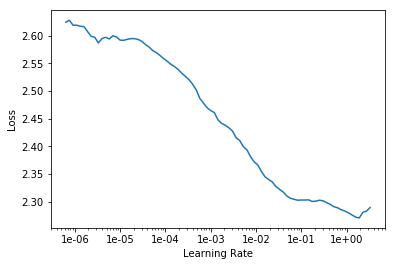

In [19]:
learn.lr_find()
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(20, max_lr=5e-02)

epoch,train_loss,valid_loss,accuracy,time
0,1.787285,1.783614,0.386000,00:40
1,1.587734,1.885531,0.378000,00:41
2,1.365619,1.382056,0.550000,00:41
3,1.272898,1.545737,0.558000,00:42
4,1.190175,3.258584,0.602000,00:42
5,1.084972,1.395327,0.586000,00:42
6,1.000707,0.931450,0.706000,00:42
7,0.927108,0.822750,0.750000,00:42
8,0.889800,52.707489,0.746000,00:42
9,0.824959,0.802874,0.754000,00:42


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


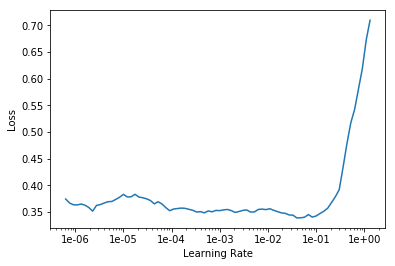

In [21]:
learn.lr_find()
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(2, max_lr=5e-04)

epoch,train_loss,valid_loss,accuracy,time
0,0.364914,0.386389,0.888000,00:41
1,0.349063,0.381797,0.890000,00:42


In [23]:
learn.fit_one_cycle(3, max_lr=1e-05)

epoch,train_loss,valid_loss,accuracy,time
0,0.358302,0.640800,0.880000,00:41
1,0.361011,0.387366,0.890000,00:42
2,0.360133,227.787643,0.886000,00:42
